# Implementacja VQ-VAE
Póki co spróbuję dla danych z Fashion-MINST potem będzie można dostosować do naszego datasetu. Kod jest taki sam jak w poradniku https://www.youtube.com/watch?v=ZNRNddl9owI - polecam obejrzeć !

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils

import os
import random
import numpy as np
import math
import  IPython
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch
from PIL import Image
import io
from pathlib import Path

In [2]:
# parameters
batch_size = 64
lr = 1e-4

root = "../../datasets"
use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")

In [3]:
use_cuda

False

In [13]:
# Define our transform
# We'll upsample the images to 32x32 as it's easier to contruct our network
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

test_transform = transforms.Compose([transforms.Resize(32),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5])])

train_set = Datasets.FashionMNIST(root=root, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

test_set = Datasets.FashionMNIST(root=root, train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

## Definicja sieci
Opis: (z kursu pytorch)
The structure of a VQ-VAE is similar to a standard Autoencoder, but instead of producing continuous latent vectors, the encoder maps inputs to discrete latent codes from a fixed codebook. The encoder outputs are quantized by selecting the closest codebook vector for each input, which is then passed to the decoder for reconstruction.

Unlike VAEs, VQ-VAEs don't sample from a distribution like N(μ,σ). Instead, the quantization step enforces a discrete, structured latent space. During training, the model uses a combination of reconstruction and commitment losses to ensure the encoder learns meaningful codebook representations.

In [14]:
class VectorQuantizer(nn.Module):
    def __init__(self, code_book_size, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.code_book_size = code_book_size
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(code_book_size, embedding_dim)
        self.embedding.weight.data.uniform_(-1/code_book_size, 1/code_book_size)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # BSxCxHxW --> BSxHxWxC
        input_shape = inputs.shape

        flat_input = inputs.view(-1, 1, self.embedding_dim)  # BSxHxWxC --> BS*H*Wx1xC

        # Calculate the distance between each embedding and each codebook vector
        distances = (flat_input - self.embedding.weight.unsqueeze(0)).pow(2).mean(2)  # BS*H*WxN

        # Find the closest codebook vector
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # BS*H*Wx1

        # Select that codebook vector
        quantized = self.embedding(encoding_indices).view(input_shape)

        # Create loss that pulls encoder embeddings and codebook vector selected
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Reconstruct quantized representation using the encoder embeddings to allow for
        # backpropagation of gradients into encoder
        if self.training:
            quantized = inputs + (quantized - inputs).detach()

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices.reshape(input_shape[0], -1)


class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.norm1 = nn.GroupNorm(8, channels)
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.norm2 = nn.GroupNorm(8, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        skip = x

        x = F.elu(self.norm1(x))
        x = F.elu(self.norm2(self.conv1(x)))
        x = self.conv2(x) + skip
        return x


# We split up our network into two parts, the Encoder and the Decoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn2 = nn.GroupNorm(8, channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x = F.elu(self.bn1(x))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)

        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.GroupNorm(8, channels_in)

        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = self.up_nn(F.elu(self.bn1(x_in)))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, latent_channels=32):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

        self.conv_block1 = DownBlock(ch, ch * 2)
        self.conv_block2 = DownBlock(ch * 2, ch * 4)

        # Instead of flattening (and then having to unflatten) out our feature map and
        # putting it through a linear layer we can just use a conv layer
        # where the kernal is the same size as the feature map
        # (in practice it's the same thing)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_3 = ResBlock(ch * 4)

        self.conv_out = nn.Conv2d(4 * ch, latent_channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv_1(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = F.elu(self.res_block_3(x))

        return self.conv_out(x)


class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, latent_channels = 32):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(latent_channels, 4 * ch, 3, 1, 1)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_3 = ResBlock(ch * 4)

        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = self.res_block_3(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        return torch.tanh(self.conv_out(x))

# Whole VQ-VAE
class VQVAE(nn.Module):
    def __init__(self, channel_in, ch=16, latent_channels=32, code_book_size=64, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

        self.vq = VectorQuantizer(code_book_size=code_book_size,
                                  embedding_dim=latent_channels,
                                  commitment_cost=commitment_cost)

        self.decoder = Decoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

    def encode(self, x):
        encoding = self.encoder(x)
        vq_loss, quantized, encoding_indices = self.vq(encoding)
        return vq_loss, quantized, encoding_indices

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        vq_loss, quantized, encoding_indices = self.encode(x)
        recon = self.decode(quantized)

        return recon, vq_loss, quantized

In [15]:
# Get a test image
dataiter = iter(test_loader)
test_images = next(dataiter)[0]

# View the shape
test_images.shape

torch.Size([64, 1, 32, 32])

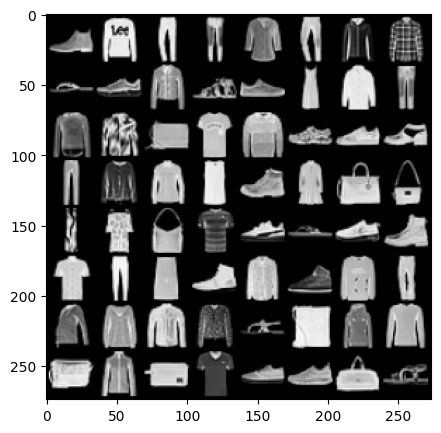

In [16]:
plt.figure(figsize = (5,5))
out = vutils.make_grid(test_images, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

## Utworzenie sieci i optimizera

In [17]:
# The number of code book embeddings
code_book_size = 32

# The number of latent embedding channels
latent_channels = 10

# Number of Training epochs
# First i will check for 1 epoch because im doing it locally for now
vq_nepoch = 1

# Create our network
vae_net = VQVAE(channel_in=test_images.shape[1], latent_channels=latent_channels, ch=16,
                code_book_size=code_book_size, commitment_cost=0.25).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda')

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=vq_nepoch, eta_min=0)

# Create loss logger
recon_loss_log = []
qv_loss_log = []
test_recon_loss_log = []
train_loss = 0

In [18]:
num_model_params = 0
for param in vae_net.parameters():
    num_model_params += param.flatten().shape[0]

print("-The VQVAE Model Has %d (Approximately %d Million) Parameters!" % (num_model_params,
                                                                          num_model_params//1e6))

-The VQVAE Model Has 568251 (Approximately 0 Million) Parameters!


### Wyjście sieci

In [19]:
# Pass through a test image to make sure everything is working
recon_data, vq_loss, quantized = vae_net(test_images.to(device))

# View the Latent vector shape
quantized.shape

torch.Size([64, 10, 8, 8])

## Start Treningu

In [20]:
pbar = trange(0, vq_nepoch, leave=False, desc="Epoch")
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (train_loss/len(train_loader)))
    train_loss = 0
    vae_net.train()
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):

        image = data[0].to(device)
        with torch.amp.autocast('cuda'):
            # Forward pass the image in the data tuple
            recon_data, vq_loss, quantized = vae_net(image)

            # Calculate the loss, try to change for better loss
            recon_loss = (recon_data - image).pow(2).mean()
            loss = vq_loss + recon_loss

        # Take a training step
        optimizer.zero_grad()
        if(device == "cuda"):
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Log the loss
        recon_loss_log.append(recon_loss.item())
        qv_loss_log.append(vq_loss.item())
        train_loss += recon_loss.item()

    lr_scheduler.step()

    vae_net.eval()
    for i, data in enumerate(tqdm(test_loader, leave=False, desc="Testing")):
        image = data[0].to(device)
        with torch.amp.autocast('cuda'):
            with torch.no_grad():
                # Forward pass the image in the data tuple
                recon_data, vq_loss, quantized = vae_net(image)

                # Calculate the loss
                recon_loss = (recon_data - image).pow(2).mean()
                loss = vq_loss + recon_loss
                test_recon_loss_log.append(recon_loss.item())

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

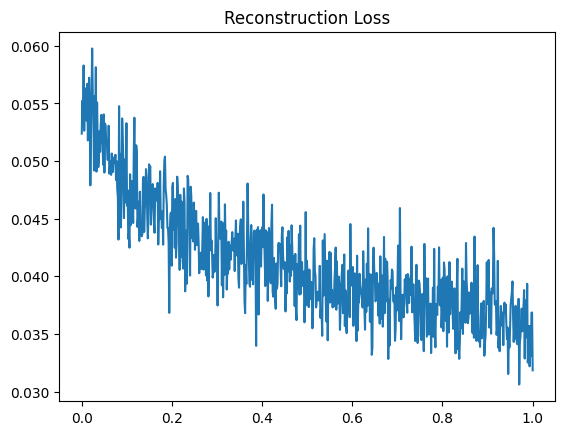

In [21]:
## Wyniki
x_train = np.linspace(0, vq_nepoch, len(recon_loss_log[200:]))
_ = plt.plot(x_train, recon_loss_log[200:])

x_test = np.linspace(0, vq_nepoch, len(test_recon_loss_log[200:]))
_ = plt.plot(x_test, test_recon_loss_log[200:])
_ = plt.title("Reconstruction Loss")

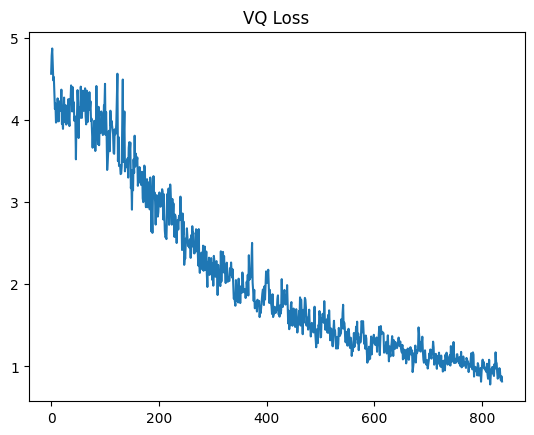

In [22]:
_ = plt.plot(qv_loss_log[100:])
_ = plt.title("VQ Loss")

In [23]:
vae_net.eval()
recon_data, vq_loss, quantized = vae_net(test_images.to(device))

In [24]:
vq_loss, quantized, encoding_indices = vae_net.encode(test_images.to(device))

In [25]:
encoding_indices[0]

tensor([ 0,  0,  0,  6, 30,  0, 30, 10,  6,  0,  6, 30, 30, 30, 30, 15,  6,  6,
        30, 27,  9, 21,  2, 30, 30, 30, 27, 29, 29, 20, 20, 20,  9, 29, 29, 29,
        29, 10,  5, 28, 22, 21,  6,  6, 29,  9, 20, 20, 10, 28, 10, 10,  0,  0,
        10, 28, 21, 21,  2,  2, 30, 21,  2,  2])

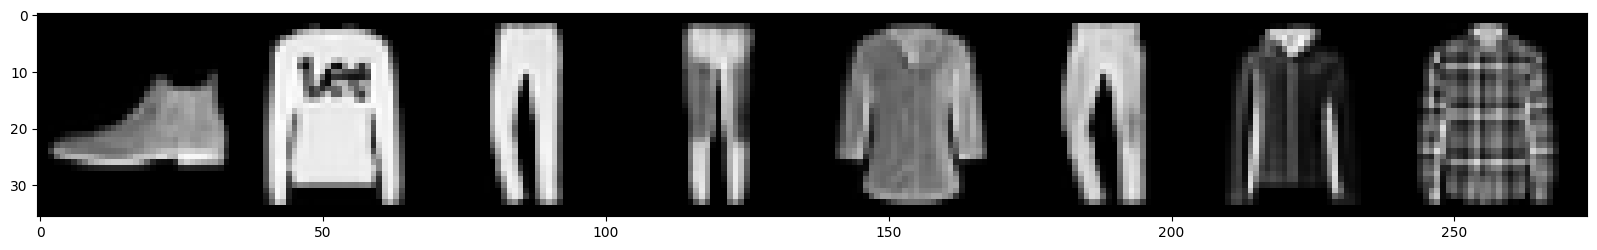

In [26]:
# ground truth
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

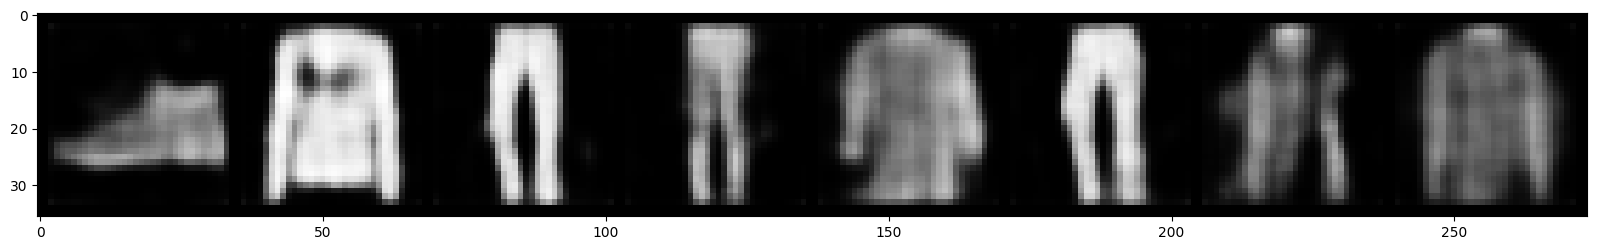

In [27]:
# reconstruction
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

# Wynik
już po jednej epoce możemy zauważyć że nasza sieć odwzorowała kształt ubrań z drobnym wyjątkiem przedostatniego ubrania które jest za bardzo rozmyte, jutro wrzucę poprawiony ten kod na collaba i popróbuję dalej dzisiaj wstępnie było sprawdzane.